## Wild Blueberry Yield Prediction Challenge
 In this Kaggle competition, we worked
with the Wild Blueberry Yield Prediction Dataset to explore the relationships between multiple variables
and predict yield using multiple linear regression. We implemented regression from scratch. We explored multi-variate OLS and kernel regression techniques and used the code implemented in previous questions. Then we selected an approach that gives us the least error (MAE) and fitted our model to predict yield on test data.

### Load the data

In [71]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('../train.csv', index_col='id', sep=',')
df_test = pd.read_csv('../test.csv', index_col='id', sep=',')

df_new=df.copy()

### Plot the features to see their distribution

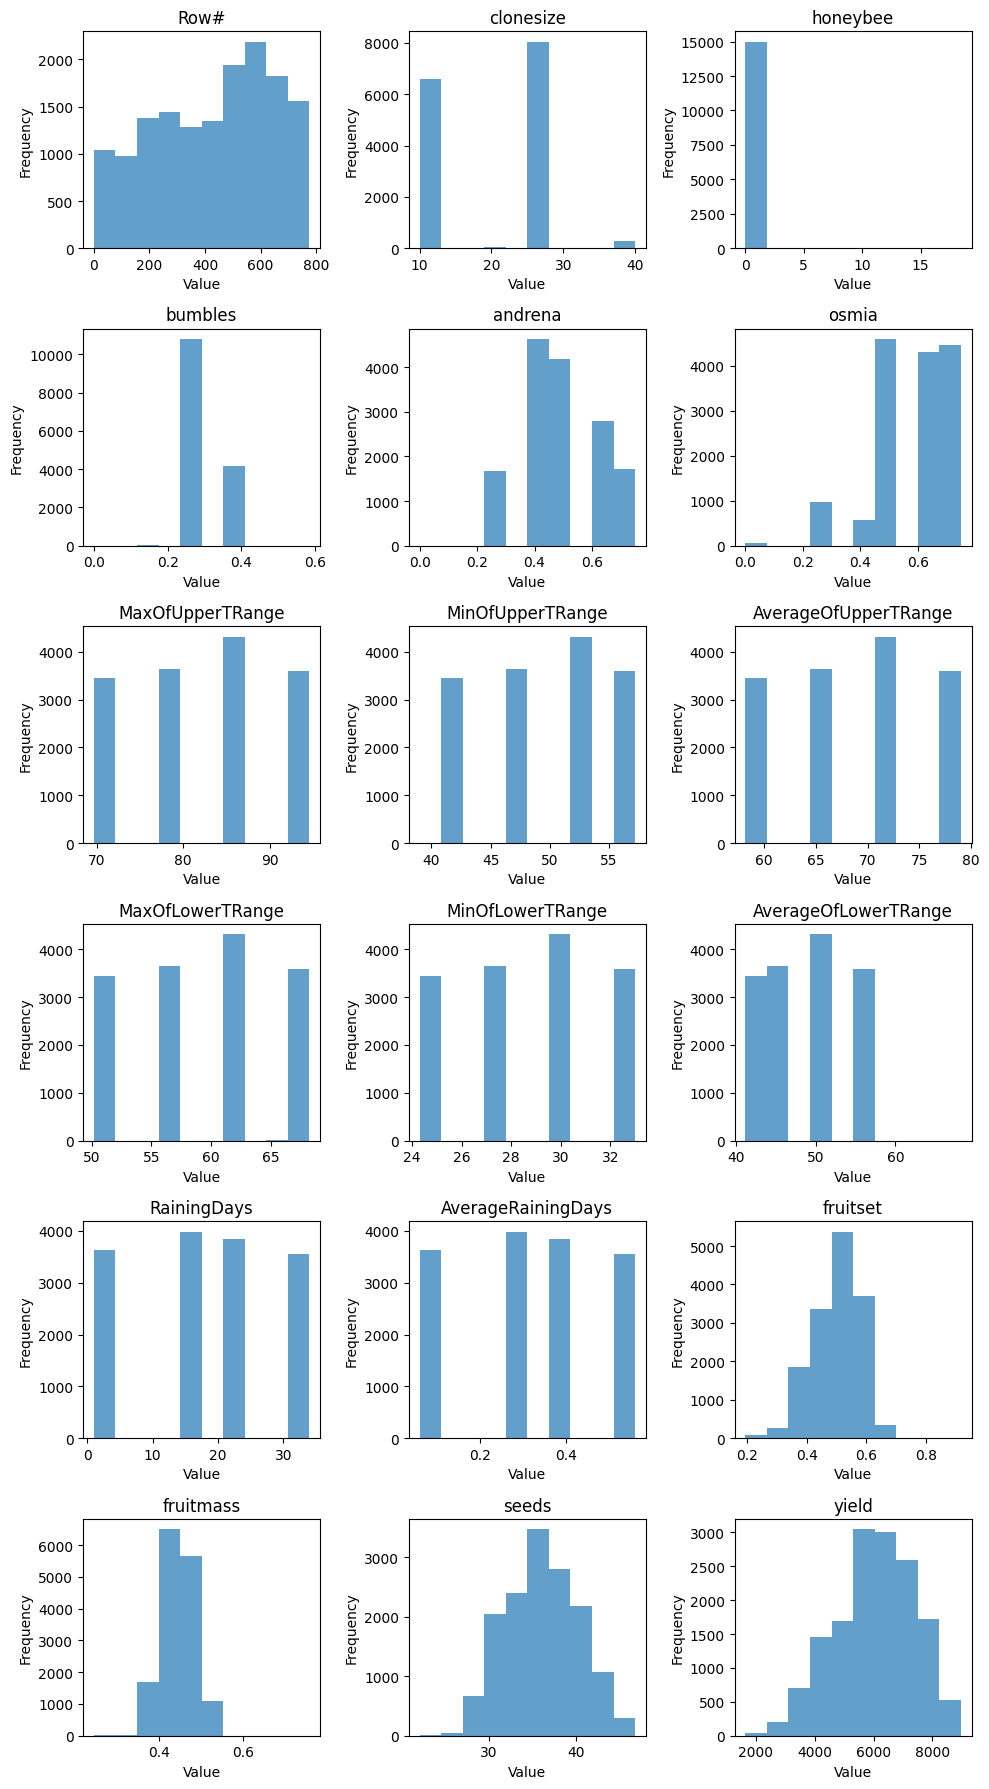

In [72]:
# Set the number of rows and columns for subplots
num_features = len(df.columns)
num_cols = 3  # Number of columns for subplots
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and plot
for i, column in enumerate(df.columns):
    axes[i].hist(df[column], bins=10, alpha=0.7)
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Analyzing features with heavy correlation among themselves
Looking at the above plot, we find that features with temparature range (Max, Min, Average etc.) and raining days have very similar plots. These features may have high correaltion among themselves. To find out correlation, we use pairplots and Pearson correlation coefficient.

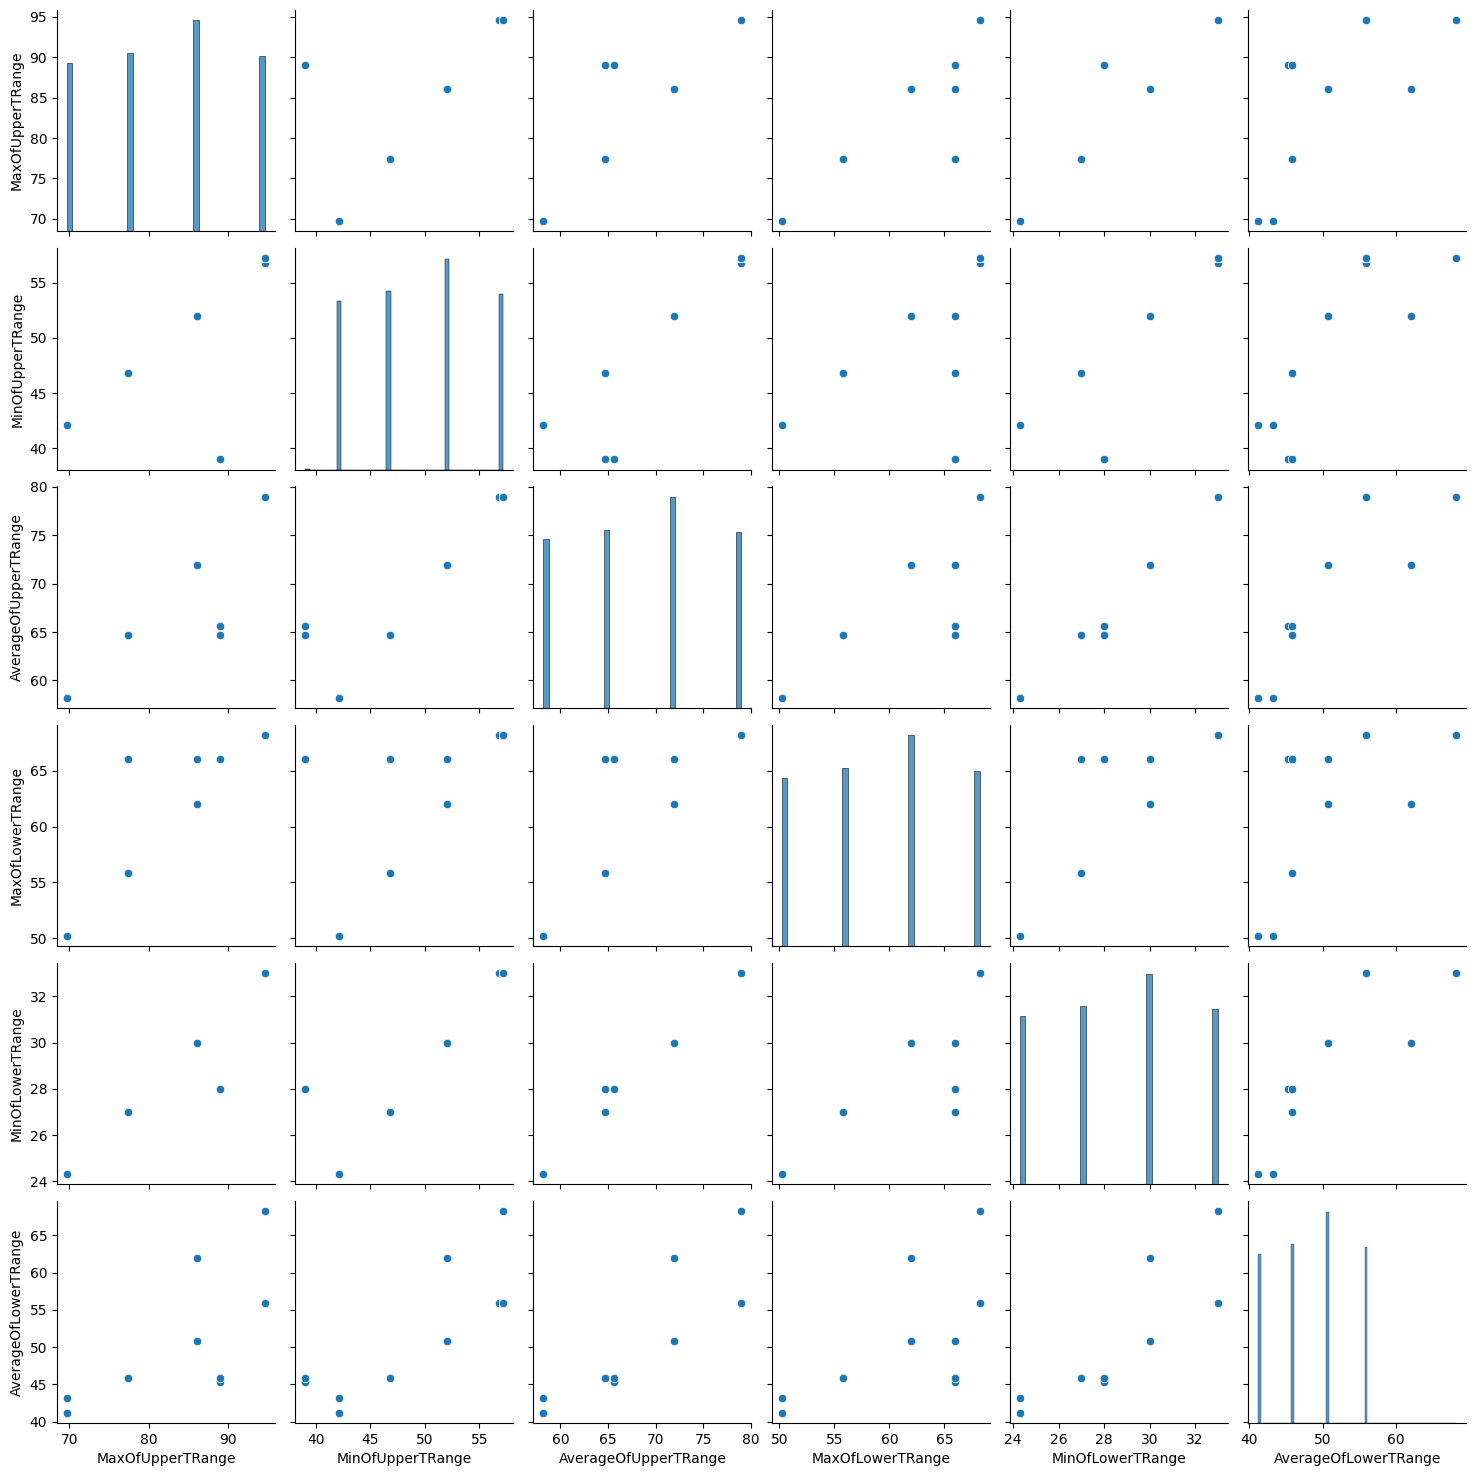

In [73]:
selected_features = ['MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange','MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange']

# Create pairplot for the selected features
sns.pairplot(df[selected_features])
plt.show()

In [74]:
corr = df[['MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange']].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

corr = df[['MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange']].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

corr = df[['MaxOfLowerTRange','MaxOfUpperTRange', 'AverageOfLowerTRange', 'AverageOfUpperTRange']].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

Pearson correlation coefficient matrix of each variables:
                       MaxOfUpperTRange  MinOfUpperTRange  AverageOfUpperTRange
MaxOfUpperTRange              1.000000          0.999274              0.999844
MinOfUpperTRange              0.999274          1.000000              0.999770
AverageOfUpperTRange          0.999844          0.999770              1.000000
Pearson correlation coefficient matrix of each variables:
                       MaxOfLowerTRange  MinOfLowerTRange  AverageOfLowerTRange
MaxOfLowerTRange              1.000000          0.999753              0.999323
MinOfLowerTRange              0.999753          1.000000              0.999653
AverageOfLowerTRange          0.999323          0.999653              1.000000
Pearson correlation coefficient matrix of each variables:
                       MaxOfLowerTRange  MaxOfUpperTRange  \
MaxOfLowerTRange              1.000000          0.999897   
MaxOfUpperTRange              0.999897          1.000000   
AverageOfLo

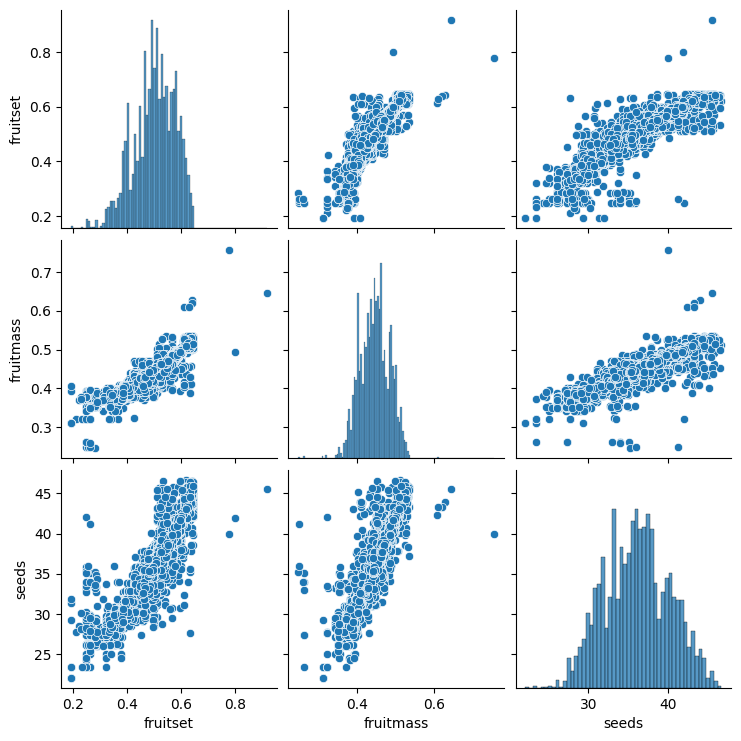

Pearson correlation coefficient matrix of each variables:
            fruitset  fruitmass     seeds
fruitset   1.000000   0.937357  0.947179
fruitmass  0.937357   1.000000  0.941995
seeds      0.947179   0.941995  1.000000


In [75]:
selected_features = ['fruitset', 'fruitmass', 'seeds']

# Create pairplot for the selected features
sns.pairplot(df[selected_features])
plt.show()

corr = df[selected_features].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

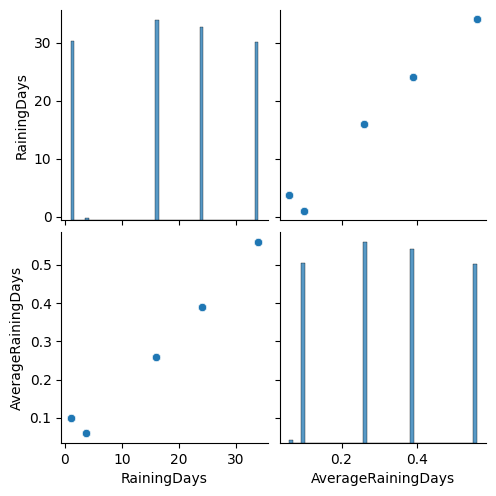

Pearson correlation coefficient matrix of each variables:
                     RainingDays  AverageRainingDays
RainingDays            1.000000            0.991722
AverageRainingDays     0.991722            1.000000


In [76]:
selected_features = ['RainingDays', 'AverageRainingDays']

# Create pairplot for the selected features
sns.pairplot(df[selected_features])
plt.show()

corr = df[selected_features].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

High correlation between these features implies they may be dependent on each other. We may consder dropping them because they don't give any new information on the yield data

### Define functions used for regression
Now we define our kernel regression functions, multiple linear regression, and corresponding error(MAE) functions. We shuffle and split the data using k-fold cross validation method. Then we train the model and minimize error by cross-validation.

1. Multi-feature Kernel regression

In [77]:
# Different Kernel functions

def gaussian_kernel(x1, x2, h):
    normalized_difference = (x1 - x2).astype(float) / h
    return np.exp(- (normalized_difference ** 2)/2) / np.sqrt(2 * np.pi)

def uniform_kernel(x1, x2, h):
    normalized_difference = (x1 - x2).astype(float) / h
    return (np.abs(normalized_difference)<1).astype(float)/2

def epanechnikov_kernel(x1, x2, h):
    normalized_difference = (x1 - x2).astype(float) / h
    return np.maximum(1-normalized_difference**2,0)*0.75


def shuffle_and_split(df, k):
    """
    Shuffle a DataFrame and split it into k datasets
    Returns:
        A list containing k DataFrames
    """
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=1, random_state=4).reset_index(drop=True)
    
    # Split the DataFrame into k datasets
    split_dfs = np.array_split(shuffled_df, k)
    
    return split_dfs

def kernel_regression_multifeature(train_data, x, p, kernel, h):
    """
    Evaluate the value of estimated kernel regression function at a point x=(x1,x2,...xk) based on the training data ,
    specified kernel function ,bandwidth h and parameter p used to calculate distance between 2 points as 
    distance = (sum(xi_1-xi_2)**p)^1/p
    """
    dist = (np.transpose(train_data[:, :-1]) - x[:,None])
    dist_p = np.power(np.sum(dist**p, axis=0),float(1)/p) # p-norm distance calculation

    #calculating the weights
    k_x_xi=kernel(dist_p,0,h)
    sum1=np.sum(k_x_xi)

    #multiplying weights with y_i
    k_x_xi_y=k_x_xi*train_data[:,-1]
    sum2=np.sum(k_x_xi_y)
    
    #return mean of y_i if weights are all 0
    if(sum1==0): return np.mean(train_data[:,-1])
    return sum2/sum1

def calc_error_kernel(train_data, cv_data, kernel, h):
    """
    Evaluate the absolute error of kernel density function estimated using the training data on cv_data 
    """
    mae=0

    for i in range(cv_data.shape[0]):
        est = kernel_regression_multifeature(train_data, cv_data[i][:-1], 2, kernel, h)
        mae+=np.abs(est-cv_data[i][-1])

    return mae

def calc_mae_kernel(data, kernel, h, k):
    """
    Evaluate the risk of kernel regression estimation using k-fold cross validation 
    Input :
    data - complete data
    kernel - gaussian/uniform/epanechnikov kernel
    h - bandwidth
    k - for k-fold cross validation
    """
    split_data=shuffle_and_split(data, k)
    total_error=0

    for i in range(k):
        # Concatenate test DataFrames into a single DataFrame
        combined_df = pd.concat([df for j, df in enumerate(split_data) if j != i] , ignore_index=True)

        # Convert the combined DataFrame to a NumPy array
        train_data = combined_df.to_numpy()
        test_data = split_data[i].to_numpy()
        
        total_error+=calc_error_kernel(train_data, test_data, kernel, h)

    return total_error/data.shape[0]

2. Multi-variate Least Square regression 

In [78]:

def train_multiple_regression(train_data):
    # Returns least square estimator of the weights of each feature
    Y=train_data[:,-1] 
    X=train_data[:,:-1]
    X=np.concatenate((np.ones_like(Y)[:, np.newaxis], X), axis=1) # add a column  of ones

    # Least square estimate is obtained by 
    # B=(X'X)^-1.(X'Y)  (X' is X.Transpose())
    XtX=np.matmul(X.transpose(),X)
    XtY=np.matmul(X.transpose(),Y)
    B=np.matmul(np.linalg.inv(np.float64(XtX)),XtY)
    return B

def predict_multiple_regression(train_data, test_data):
    # Train and predict on Test data
    B=train_multiple_regression(train_data)
    X_test=np.concatenate((np.ones(test_data.shape[0])[:, np.newaxis], test_data), axis=1)
    return np.matmul(X_test, B)

def calc_error_regr(train_data, cv_data):
    """
    Evaluate the absolute error of least square estimated using the training data on cv_data 
    """
    mae=0
    pred= predict_multiple_regression(train_data, cv_data[:,:-1])
    residual=pred-cv_data[:,-1]
    mae=np.sum(np.abs(pred-cv_data[:,-1]))

    return mae, residual

def calc_mae_regr(data, k):
    """
    Evaluate the risk of multi-linear least square regression estimation using k-fold cross validation 
    Input :
    data - complete data
    k - for k-fold cross validation
    """
    split_data=shuffle_and_split(data, k)
    total_error=0
    res=np.zeros((1, 3000))
    
    for i in range(k):
        # Concatenate test DataFrames into a single DataFrame
        combined_df = pd.concat([df for j, df in enumerate(split_data) if j != i] , ignore_index=True)

        # Convert the combined DataFrame to a NumPy array
        train_data = combined_df.to_numpy()
        test_data = split_data[i].to_numpy()
        mae, residual=calc_error_regr(train_data, test_data)
        res=res+residual
        total_error+=mae
    
    # print(res.shape)
    res=res.flatten()
    return total_error/data.shape[0], res/k


3. Mixed Kernel and Linear regression models

In [79]:

def calc_error_mixed(train_data, cv_data, kernel, h):
    """
    Evaluate the square error of kernel density function estimated using the training data on cv_data 
    """
    mae=0

    pred1 = predict_multiple_regression(train_data, cv_data[:,:-1])
    pred2 = [kernel_regression_multifeature(train_data, cv_data[i][:-1], 2, kernel, h) for i in range(cv_data.shape[0])]
    pred2 = np.array(pred2)

    # Weights for multiple linear and kernel regression
    est= 0.95*pred1 + 0.05*pred2
    mae=np.sum(np.abs(est-cv_data[:,-1]))

    return mae


def calc_mae_mixed(data, k, kernel, h):

    """
    Evaluate the risk of kernel regression estimation using k-fold cross validation 
    Input :
    data - complete data
    kernel - gaussian/uniform/epanechnikov kernel
    h - bandwidth
    k - for k-fold cross validation
    """

    split_data=shuffle_and_split(data, k)
    total_error=0

    for i in range(k):
        # Concatenate test DataFrames into a single DataFrame
        combined_df = pd.concat([df for j, df in enumerate(split_data) if j != i] , ignore_index=True)

        # Convert the combined DataFrame to a NumPy array
        train_data = combined_df.to_numpy()
        test_data = split_data[i].to_numpy()
        
        total_error+=calc_error_mixed(train_data, test_data, kernel, h)

    return total_error/data.shape[0]


Predict functions ( helper functions for generating submission for kaggle )

In [80]:

def predict(kernel, h):

    with open("../sample_submission.csv", 'w') as f:
        f.write("id,yield\n")
        for i in range(10000):
            est = kernel_regression_multifeature(df.to_numpy(), df_test.to_numpy()[i][:], 2, kernel, h)
            j = i+15000
            f.write("{},{}\n".format(j,est))

def predict_regr():

    with open("../sample_submission.csv", 'w') as f:
        f.write("id,yield\n")
        df1=df
        df2=df_test
        est = predict_multiple_regression(df1.to_numpy(), df2.to_numpy())
        for i in range(10000):
            j = i+15000
            f.write("{},{}\n".format(j,est[i]))


### Comparing performance of different models
#### 1.Kernel regression

In [81]:

#dropping some of the correlated features was found to improve performance
selected_features=['Row#', 'clonesize', 'honeybee', 'AverageOfUpperTRange', 'RainingDays', 'seeds', 'yield']

# Varying h (bandwidth) leads to the optimum value of around 1.8
print("error=", calc_mae_kernel(df[selected_features], gaussian_kernel, 1.8, 5))

# error= 511.0968243174302 (best from kernel)

error= 511.0968243174302


#### 2.Multi-Linear Regression

In [82]:

#using all the features
err, residual=calc_mae_regr(df, 5)
print("error=",err)

# error= 270.2285534507598

error= 270.2285534507598


#### 3.Mixed model

In [83]:

#using all the features
print("error=", calc_mae_mixed(df, 5, gaussian_kernel, 1.4))

# error= 271.76232985662347

error= 271.762351685742


#### 4. After standardization 

In [84]:

# Scaling all features to same scale so that trained model is not biased towards higher value features
yield_factor=df['yield'].std()
df_std=(df-df.mean())/df.std()

print("error=", calc_mae_regr(df_std, 5, std=True)*yield_factor)

# error= 270.22856283585713 
# Normalization has no/little effect on the model

TypeError: calc_mae_regr() got an unexpected keyword argument 'std'

#### 5.Removing Outliers from the data 

(We have removed the outliers from the test data as well, thus exaggerating the mean absolute error, however this model indeed performs better than above on kaggle!)

In [13]:
# Removing outliers from data
df_new=df[df['yield']>=3000]
df_new=df_new[df_new['yield']<=8500]

print("error=", calc_mae_regr(df_new, 5))

# error= 253.7285651362452

error= 253.72854302042245


#### 6.Trying Higher Order Terms

As can be seen from the scatter plots below, the features exhibit weak correlation with the yield except for three features i.e seeds, fruitset and fruitmass. So, we try to insert higher order terms for these features and find out the lowest MAE is obtained with degree 3.

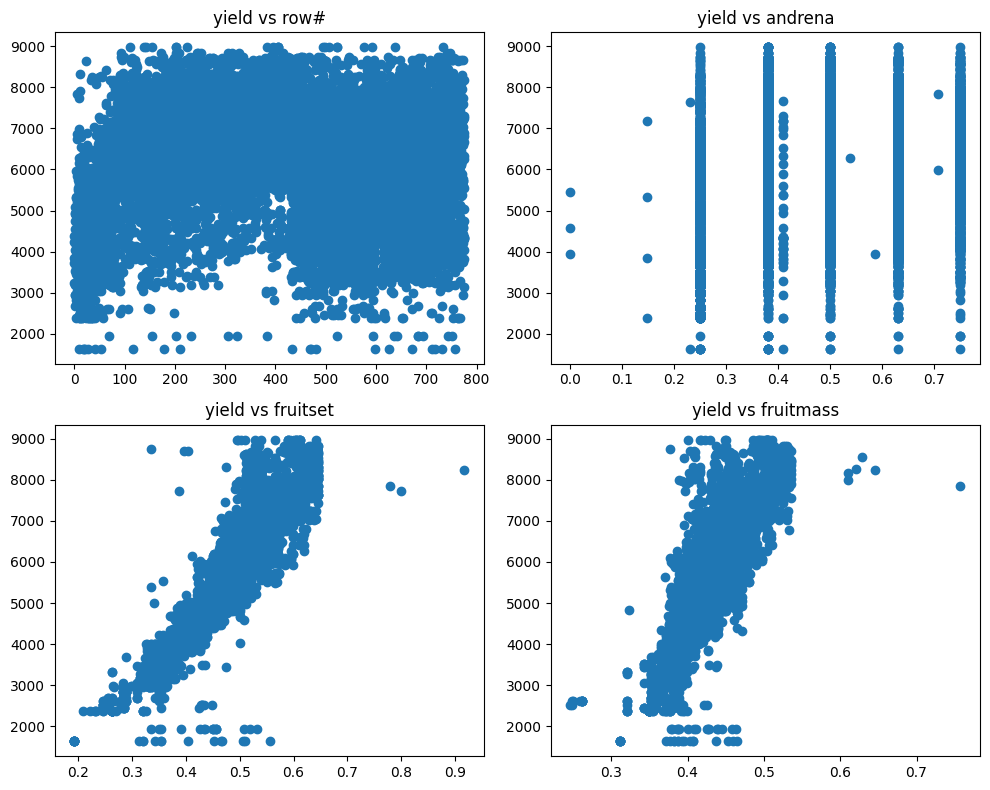

error with degree2= 273.16800096212177
error with degree3= 267.31761563793077
error with degree4= 272.43703849576065
error with degree5= 280.17343313972685
error with degree6= 289.60876600350485
error with degree7= 10300.157547738545


In [18]:

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Plot 1
axs[0, 0].scatter(df['Row#'], df['yield'])  # Replace x1 and y1 with your data
axs[0, 0].set_title('yield vs row#')

# Plot 2
axs[0, 1].scatter(df['andrena'], df['yield'])  # Replace x2 and y2 with your data
axs[0, 1].set_title('yield vs andrena')

# Plot 3
axs[1, 0].scatter(df['fruitset'], df['yield']) # Replace x3 and y3 with your data
axs[1, 0].set_title('yield vs fruitset')

# Plot 4
axs[1, 1].scatter(df['fruitmass'], df['yield'])  # Replace x4 and y4 with your data
axs[1, 1].set_title('yield vs fruitmass')

# Adjust layout
plt.tight_layout()
plt.show()

#trying to find the optimal degree of terms to be fit
df_high=df
required_features= ['seeds', 'fruitset', 'fruitmass']
higher_order_features =  ['Row#','clonesize','honeybee','bumbles','andrena','osmia','MaxOfUpperTRange','MinOfUpperTRange',
'AverageOfUpperTRange','MaxOfLowerTRange','MinOfLowerTRange','AverageOfLowerTRange','RainingDays','AverageRainingDays',
'fruitset','fruitmass','seeds']
for i in range(2,8):
    for feature in required_features:
        df_high["{}{}".format(feature,i)]=df[feature]**i
        higher_order_features.append("{}{}".format(feature,i))
    print("error with degree{}=".format(i), calc_mae_regr(df_high[higher_order_features + ['yield',]], 5))


# error with degree3= 267.31761563793077


#### 7.Trying to combine features to create newer ones

In [22]:
#creating new features
df_comb = df

df_comb['seedsfruitset'] = df['seeds'] * df ['fruitset']
df_comb['seedsfruitmass'] = df['seeds'] * df ['fruitmass']
df_comb['fruitsetmass'] = df['fruitset'] * df['fruitmass']

required_features= ['seeds', 'fruitset', 'fruitmass', 'seedsfruitset', 'seedsfruitmass', 'fruitsetmass']
higher_order_features= ['seeds', 'fruitset', 'fruitmass', 'seedsfruitset', 'seedsfruitmass', 'fruitsetmass']

# Finding the optimum degree of these new features to be used in regression
for i in range(2,8):
    for feature in required_features:
        df_comb["{}{}".format(feature,i)]=df[feature]**i
        higher_order_features.append("{}{}".format(feature,i))
    print("error with degree{}=".format(i), calc_mae_regr(df_comb[higher_order_features + ['yield',]], 5))

# Generate predictions for submission on kaggle
# degree 3 works better than degree 2 in this case!
def predict_final():

    with open("../sample_submission.csv", 'w') as f:
        f.write("id,yield\n")

        df_comb=df
        df_comb['seedsfruitset'] = df['seeds'] * df ['fruitset']
        df_comb['seedsfruitmass'] = df['seeds'] * df ['fruitmass']
        df_comb['fruitsetmass'] = df['fruitset'] * df['fruitmass']

        df_test['seedsfruitset'] = df_test['seeds'] * df_test ['fruitset']
        df_test['seedsfruitmass'] = df_test['seeds'] * df_test ['fruitmass']
        df_test['fruitsetmass'] = df_test['fruitset'] * df_test['fruitmass']

        required_features= ['seeds', 'fruitset', 'fruitmass', 'seedsfruitset', 'seedsfruitmass', 'fruitsetmass']
        higher_order_features= ['seeds', 'fruitset', 'fruitmass', 'seedsfruitset', 'seedsfruitmass', 'fruitsetmass']
        for i in range(2,4):
            for feature in required_features:
                df_comb["{}{}".format(feature,i)]=df[feature]**i
                df_test["{}{}".format(feature,i)]=df_test[feature]**i
                higher_order_features.append("{}{}".format(feature,i))

        df1=df_comb[higher_order_features + ['yield',]]
        df2=df_test[higher_order_features]
        est = predict_multiple_regression(df1.to_numpy(), df2.to_numpy())
        for i in range(10000):
            j = i+15000
            f.write("{},{}\n".format(j,est[i]))

predict_final()

error with degree2= 266.3229490299111
error with degree3= 269.1271114371455
error with degree4= 272.78204559385415
error with degree5= 287.90090144307254
error with degree6= 434.7289385757825
error with degree7= 30194.651699305803


### Assumption Testing 
This assumes that the error terms of the model are normally distributed. The curve fitted validates our assumption.

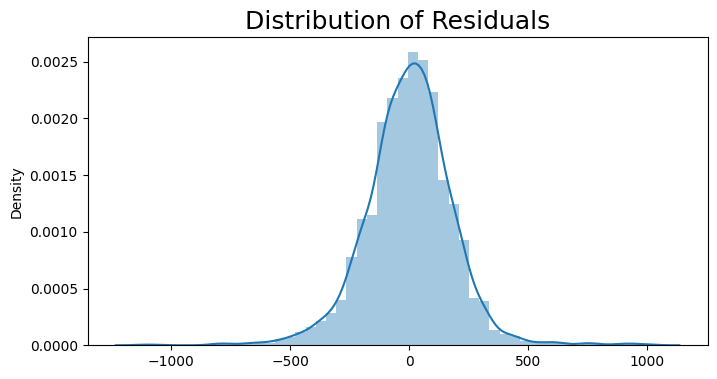

In [70]:
# FOR NORMALITY ASSUMPTION

# Plotting the residuals distribution
plt.subplots(figsize=(8, 4))
plt.title('Distribution of Residuals', fontsize=18)
sns.distplot(residual)
plt.show()